# Task 1. Classical Image Analysis Pipeline

### Single-Image Representative Workflow

## 1A Denoising

Data type: uint8
Coordinate system dimensions: (416, 416, 4)


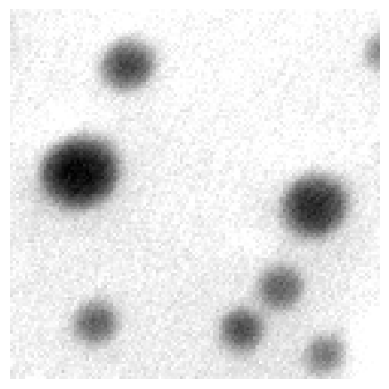

In [21]:
import matplotlib.pyplot as plt
from skimage.io import imread

# Load & visualize single image file
img = imread("raw_data/11500X00.png")

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show

print("Data type:", img.dtype)
print("Coordinate system dimensions:", img.shape)

In [5]:
import numpy as np

# Convert image file to 2D grayscale
if img.shape[-1] == 4:
    img = img[..., :3] # Drop alpha channel if present

from skimage.color import rgb2gray

# Convert to 2D grayscale
img_gray = rgb2gray(img)

print("Data type:", img_gray.dtype)
print("Coordinate system dimensions:", img_gray.shape)

Data type: float64
Coordinate system dimensions: (416, 416)


In [6]:
# Check intensity range
print("Minimum intensity:", img_gray.min())
print("Maximum intensity:", img_gray.max())

Minimum intensity: 0.0
Maximum intensity: 1.0


#### Explore filters for optimal SNR (signal-to-noise ratio)

In [10]:
import numpy as np

# Compute SNR (μ/σ)
mu = float(np.mean(img_gray))
sigma = float(np.std(img_gray))
snr = np.inf if sigma == 0 else mu / sigma

print(f"mu = {mu:.6f}") # sean intensity
print(f"sigma = {sigma:.6f}") # standard deviation of intensity
print(f"SNR = {snr:.6f}") # signal-to-noise ratio

mu = 0.882120
sigma = 0.181772
SNR = 4.852892


mu (gauss) = 0.882120
sigma (gauss) = 0.179293
SNR (gauss) = 4.919984


<function matplotlib.pyplot.show(close=None, block=None)>

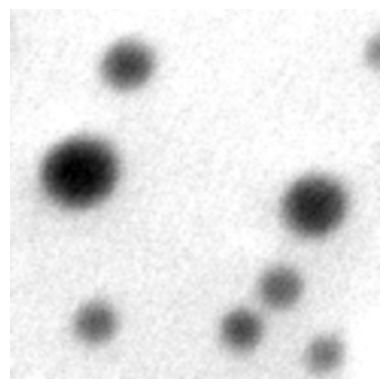

In [18]:
from skimage.filters import gaussian

# Apply a Gaussian filter
img_gauss = gaussian(img_gray, sigma=1.5)

# Recompute SNR (μ/σ)
mu_g = img_gauss.mean()
sigma_g = img_gauss.std()
snr_g = mu_g / sigma_g

print(f"mu (gauss) = {mu_g:.6f}")
print(f"sigma (gauss) = {sigma_g:.6f}")
print(f"SNR (gauss) = {snr_g:.6f}")

plt.imshow(img_gauss, cmap="gray")
plt.axis("off")
plt.show

Median SNR: 4.863661033112562


<function matplotlib.pyplot.show(close=None, block=None)>

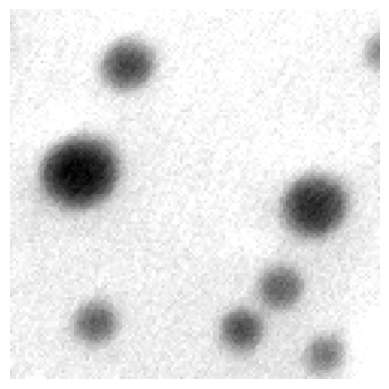

In [19]:
from skimage.filters import median
from skimage.morphology import disk

# Apply a Median filter
img_med = median(img_gray, disk(2))

mu_m = img_med.mean()
sigma_m = img_med.std()
snr_m = mu_m / sigma_m

print("Median SNR:", snr_m)

plt.imshow(img_med, cmap="gray")
plt.axis("off")
plt.show

Bilateral SNR: 4.915149661754961


<function matplotlib.pyplot.show(close=None, block=None)>

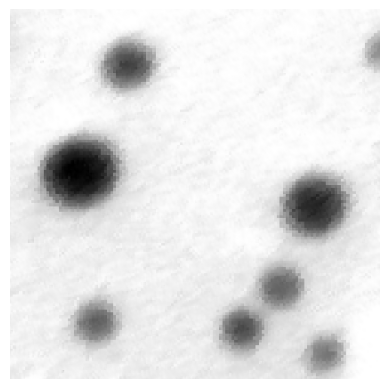

In [20]:
from skimage.restoration import denoise_bilateral

img_bilat = denoise_bilateral(
    img_gray,
    sigma_color=0.05,
    sigma_spatial=2
)

print("Bilateral SNR:", img_bilat.mean() / img_bilat.std())

plt.imshow(img_bilat, cmap="gray")
plt.axis("off")
plt.show

#### Multiple denoising strategies were evaluated (Gaussian, median, and bilateral). SNR improvements were modest, indicating the dataset was not strongly noise-limited. Bilateral filtering provided the highest SNR while preserving particle boundaries, and was therefore selected for downstream segmentation.

The TEM data is moderately clean with mild high-frequency noise to begin with. SNR is only slightly improved by mild Median, Gaussian, or Bilateral filters. So, variation in the data image is mostly coming from true particle contrast and edge gradients, rather than heavy noise. 

Filtering cannot drammatically reduce variation without also reducing real structure. 


Of the three, the Bilateral filter is the strongest candidate moving forward and will be applied in downstream pipeline. This filter smooths inside uniform regions, preserves boundaries, and does not blur particle edges as aggressively as alternative options. 

In [23]:
# FOR PIPELINE

img_denoised = denoise_bilateral(
    img_gray,
    sigma_color=0.05,
    sigma_spatial=2
)

## 1B Thresholding (Otsu)

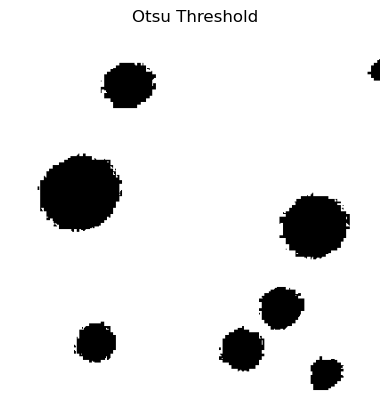

Otsu threshold value: 0.6814500246113282


In [24]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_denoised)
binary = img_denoised > thresh

import matplotlib.pyplot as plt
plt.imshow(binary, cmap="gray")
plt.title("Otsu Threshold")
plt.axis("off")
plt.show()

print("Otsu threshold value:", thresh)

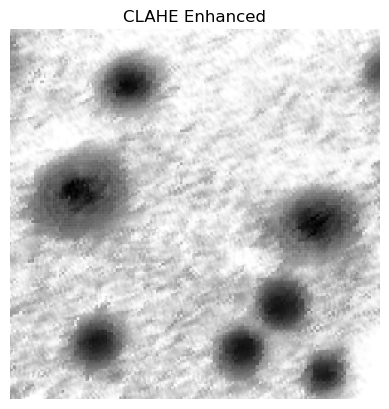

In [26]:
from skimage import exposure

img_clahe = exposure.equalize_adapthist(
    img_denoised,
    clip_limit=0.02
)

plt.imshow(img_clahe, cmap="gray")
plt.title("CLAHE Enhanced")
plt.axis("off")
plt.show()

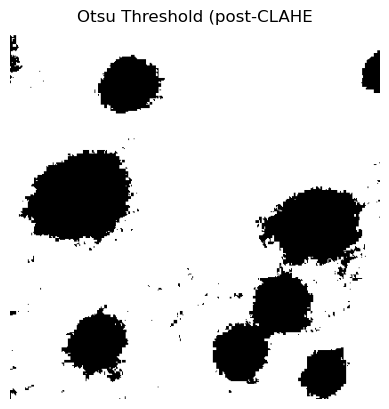

Otsu threshold value: 0.626953125


In [27]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_clahe)
binary = img_clahe > thresh

import matplotlib.pyplot as plt
plt.imshow(binary, cmap="gray")
plt.title("Otsu Threshold (post-CLAHE")
plt.axis("off")
plt.show()

print("Otsu threshold value:", thresh)

Otsu threshold (denoised): 0.6814500246113282
Otsu threshold (CLAHE):    0.626953125


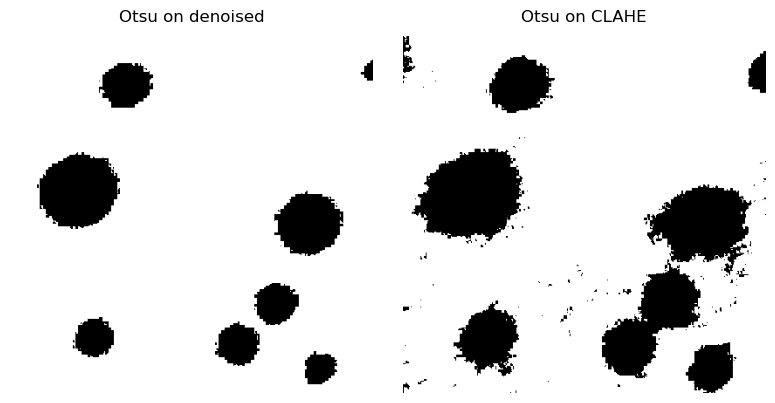

In [28]:
from skimage.filters import threshold_otsu

# Otsu on denoised
t_den = threshold_otsu(img_denoised)
bin_den = img_denoised > t_den

# Otsu on CLAHE
t_clahe = threshold_otsu(img_clahe)
bin_clahe = img_clahe > t_clahe

print("Otsu threshold (denoised):", t_den)
print("Otsu threshold (CLAHE):   ", t_clahe)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(bin_den, cmap="gray")
ax[0].set_title("Otsu on denoised")
ax[0].axis("off")

ax[1].imshow(bin_clahe, cmap="gray")
ax[1].set_title("Otsu on CLAHE")
ax[1].axis("off")
plt.tight_layout()
plt.show()

#### CLAHE (clip_limit=0.02) was tested per the assignment requirement, but the dataset already had strong contrast; CLAHE did not materially improve Otsu+Watershed segmentation. Therefore the denoised image was used for segmentation.

## 1C Watershed Separation

In [50]:
from skimage.filters import threshold_otsu
from skimage import morphology

t = threshold_otsu(img_denoised)

# Particles are DARK, so use < not >
particles = img_denoised < t

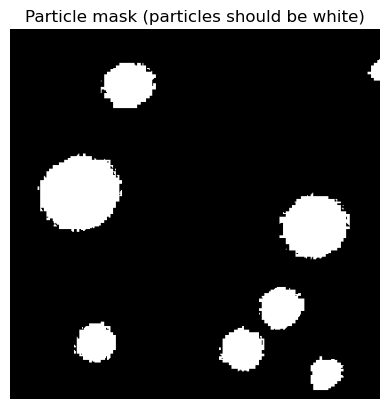

In [51]:
import matplotlib.pyplot as plt

plt.imshow(particles, cmap="gray")
plt.title("Particle mask (particles should be white)")
plt.axis("off")
plt.show()

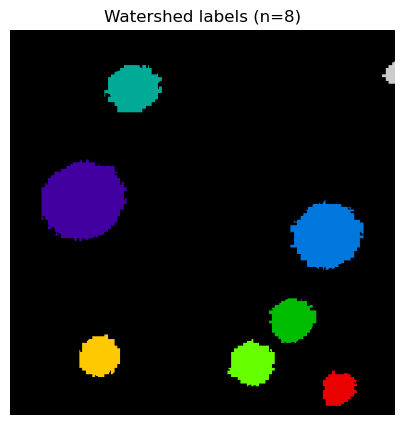

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import morphology
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# 1) Light cleanup (prof-style implementation detail)
particles_clean = morphology.remove_small_objects(particles, min_size=50)
particles_clean = morphology.remove_small_holes(particles_clean, area_threshold=50)

# 2) Distance transform + slight smoothing to suppress spurious peaks
dist = ndi.distance_transform_edt(particles_clean)
dist_s = gaussian(dist, sigma=1.0, preserve_range=True)

coords = peak_local_max(
    dist_s,
    labels=particles_clean,
    min_distance=10,           # keep your conservative choice
    footprint=np.ones((9, 9)),
)

markers = np.zeros(dist.shape, dtype=int)
markers[tuple(coords.T)] = np.arange(1, coords.shape[0] + 1)

labels = watershed(-dist_s, markers, mask=particles_clean)

plt.figure(figsize=(5,5))
plt.imshow(labels, cmap="nipy_spectral")
plt.title(f"Watershed labels (n={labels.max()})")
plt.axis("off")
plt.show()

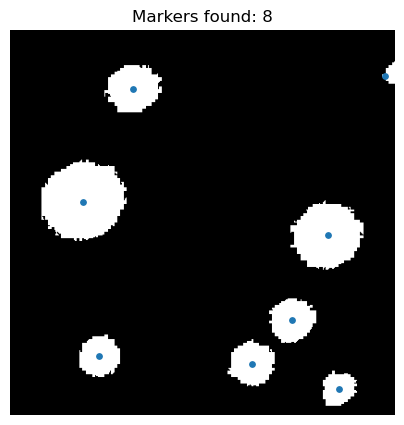

In [55]:
plt.figure(figsize=(5,5))
plt.imshow(particles_clean, cmap="gray")
plt.scatter(coords[:,1], coords[:,0], s=15)
plt.title(f"Markers found: {len(coords)}")
plt.axis("off")
plt.show()

## 1D Extract Morphological Features

In [68]:
from skimage.measure import regionprops_table
import pandas as pd

props = regionprops_table(
    labels,
    intensity_image=img_denoised,
    properties=[
        "label",
        "area",
        "equivalent_diameter",
        "eccentricity",
        "solidity",
        "mean_intensity",
    ],
)

df = pd.DataFrame(props)

df.to_csv("classical_results/classical_results.csv", index=False)
df

,label,area,equivalent_diameter,eccentricity,solidity,mean_intensity
0,1,6041.0,87.701996,0.455832,0.933550,0.311530
1,2,4171.0,72.874427,0.393675,0.908319,0.391988
2,3,2343.0,54.618680,0.498026,0.911319,0.470481
3,4,1802.0,47.899662,0.392709,0.919857,0.532167
4,5,1818.0,48.111844,0.287552,0.902233,0.495581
5,6,1552.0,44.452984,0.319596,0.924911,0.530278
6,7,1045.0,36.476504,0.497762,0.907906,0.580767
7,8,204.0,16.116478,0.831142,0.871795,0.621904


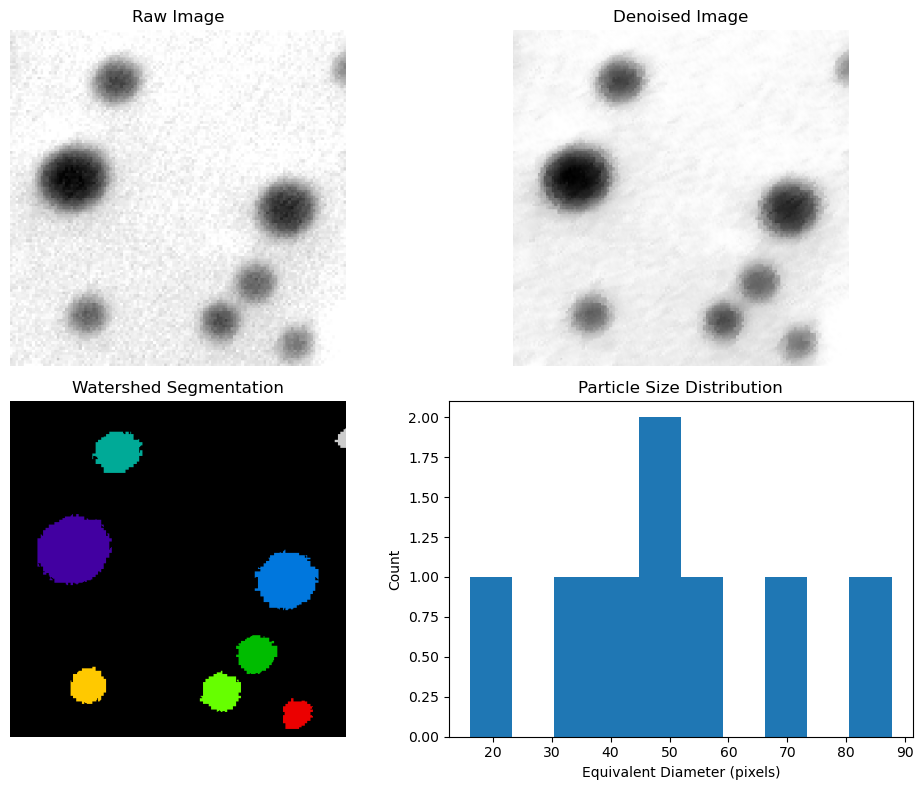

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Raw
ax[0,0].imshow(img_gray, cmap="gray")
ax[0,0].set_title("Raw Image")
ax[0,0].axis("off")

# Denoised (or CLAHE if you chose that)
ax[0,1].imshow(img_denoised, cmap="gray")
ax[0,1].set_title("Denoised Image")
ax[0,1].axis("off")

# Segmentation
ax[1,0].imshow(labels, cmap="nipy_spectral")
ax[1,0].set_title("Watershed Segmentation")
ax[1,0].axis("off")

# Size distribution
ax[1,1].hist(df["equivalent_diameter"], bins=10)
ax[1,1].set_title("Particle Size Distribution")
ax[1,1].set_xlabel("Equivalent Diameter (pixels)")
ax[1,1].set_ylabel("Count")

plt.tight_layout()
plt.show()